Importing Libraries 

In [983]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #Data Visualization
from sklearn.model_selection import train_test_split # train-test split
import seaborn as sns #data_visualization
import datetime

Data Reading

In [984]:
Read your data here...................

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0100024776,PEA llc,2020-03-20 00:00:00,2020.0,1.930490e+09,2020-02-11,20200206,20200211,20200317.0,USD,RV,1.0,NaN,12578.40,20200211.0,NAG2,1.930490e+09,0
1,U001,0100014724,DEC us,2020-01-10 00:00:00,2020.0,1.930373e+09,2020-01-08,20200108,20200108,20200111.0,USD,RV,1.0,NaN,116508.90,20200101.0,NAM2,1.930373e+09,0
2,U001,0100031704,DELHAIZE foundation,2019-06-12 00:00:00,2019.0,1.929386e+09,2019-05-28,20190528,20190528,20190612.0,USD,RV,1.0,NaN,13481.21,20190528.0,NAA8,1.929386e+09,0
3,U001,0200769623,WAL-MAR corp,2020-02-20 00:00:00,2020.0,1.930487e+09,2020-02-08,20200206,20200208,20200223.0,USD,RV,1.0,NaN,46887.73,20200208.0,NAH4,1.930487e+09,0
4,U001,0200418007,AM systems,2019-02-20 00:00:00,2019.0,1.928733e+09,2019-02-05,20190204,20190205,20190220.0,USD,RV,1.0,NaN,6237.22,20190205.0,NAA8,1.928733e+09,0


In [985]:
# Gadaring information about NaN values in the DataFrame 
df.isnull().sum()

business_code                 0
cust_number                   0
name_customer                 0
clear_date                 3334
buisness_year                 0
doc_id                        0
posting_date                  0
document_create_date          0
document_create_date.1        0
due_in_date                   0
invoice_currency              0
document type                 0
posting_id                    0
area_business             50000
total_open_amount             0
baseline_create_date          0
cust_payment_terms            0
invoice_id                    6
isOpen                        0
dtype: int64

In [986]:
print(df['area_business'].unique())
print(df['posting_id'].unique())

[nan]
[1.]


In [987]:
# posting_id is removed as it contains the values are constant
# Area_business column removed as it contains only NaN
df.drop(['area_business','posting_id'], inplace=True, axis=1) 
df.head(2)                                        

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0100024776,PEA llc,2020-03-20 00:00:00,2020.0,1.930490e+09,2020-02-11,20200206,20200211,20200317.0,USD,RV,12578.4,20200211.0,NAG2,1.930490e+09,0
1,U001,0100014724,DEC us,2020-01-10 00:00:00,2020.0,1.930373e+09,2020-01-08,20200108,20200108,20200111.0,USD,RV,116508.9,20200101.0,NAM2,1.930373e+09,0


In [988]:
# These are the 6 rows containing invoice_id == null as observed before 
df[df['invoice_id'].isnull()]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
1304,CA02,0100030194,AMAZO,2019-05-23 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190313,20190323.0,CAD,X2,16418.95,20190313.0,CA10,NaN,0
3181,CA02,0140104429,COSTCO co,2019-05-02 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190227,20190309.0,CAD,X2,52992.00,20190227.0,CA10,NaN,0
5494,CA02,0140104409,LOB us,2019-04-17 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190319,20190329.0,CAD,X2,371.40,20190319.0,CA10,NaN,0
19577,CA02,0140104429,COSTCO systems,2019-05-14 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190311,20190321.0,CAD,X2,5353.20,20190311.0,CA10,NaN,0
23821,CA02,0140104409,LOB associates,2019-12-27 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20180626,20180706.0,CAD,X2,279.60,20180626.0,CA10,NaN,0
28612,CA02,0140104409,LOB in,2019-05-08 00:00:00,2019.0,9.500000e+09,2019-03-29,20190329,20190225,20190307.0,CAD,X2,15922.44,20190225.0,CA10,NaN,0


In [989]:
# Both doc_id and invoice_id contains same value
pd.Series(df['doc_id'] == df['invoice_id']).value_counts()
# here in these 6 columns the invoice id is missing 

True     49994
False        6
dtype: int64

In [990]:
# As invoice_id and doc_id are same, we are dropping 'invoice_id' column
df.drop(['invoice_id'], inplace=True,axis=1) 

In [991]:
#Changing the format of dates
df['document_create_date.1'] = pd.to_datetime(df['document_create_date.1'], format='%Y%m%d')
df['baseline_create_date'] = pd.to_datetime(df['baseline_create_date'], format='%Y%m%d')
df['due_in_date'] = pd.to_datetime(df['due_in_date'], format='%Y%m%d')
df['clear_date'] = pd.to_datetime(df['clear_date'])
df['posting_date'] = pd.to_datetime(df['posting_date'])
df.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms,isOpen
0,U001,0100024776,PEA llc,2020-03-20,2020.0,1.930490e+09,2020-02-11,20200206,2020-02-11,2020-03-17,USD,RV,12578.40,2020-02-11,NAG2,0
1,U001,0100014724,DEC us,2020-01-10,2020.0,1.930373e+09,2020-01-08,20200108,2020-01-08,2020-01-11,USD,RV,116508.90,2020-01-01,NAM2,0
2,U001,0100031704,DELHAIZE foundation,2019-06-12,2019.0,1.929386e+09,2019-05-28,20190528,2019-05-28,2019-06-12,USD,RV,13481.21,2019-05-28,NAA8,0
3,U001,0200769623,WAL-MAR corp,2020-02-20,2020.0,1.930487e+09,2020-02-08,20200206,2020-02-08,2020-02-23,USD,RV,46887.73,2020-02-08,NAH4,0
4,U001,0200418007,AM systems,2019-02-20,2019.0,1.928733e+09,2019-02-05,20190204,2019-02-05,2019-02-20,USD,RV,6237.22,2019-02-05,NAA8,0


In [992]:
#This function can be used for sanity checking for the whole dattaframe
#It also removes the inappropiate datas
def sanitycheck(df,a,b):
    temp=df[df[a]<df[b]]
    df.drop(df[df[a]<df[b]].index,inplace=True)
    print(temp.shape[0])

In [993]:
#sanity checking with respect to document_create_date.1
sanitycheck(df,'posting_date','document_create_date.1')
sanitycheck(df,'baseline_create_date','document_create_date.1')
sanitycheck(df,'due_in_date','document_create_date.1')
sanitycheck(df,'clear_date','document_create_date.1')

#sanity checking with respect to posting_date
sanitycheck(df,'baseline_create_date','posting_date')
sanitycheck(df,'due_in_date','posting_date')
sanitycheck(df,'clear_date','posting_date')

#sanity checking with respect to baseline_create_date
sanitycheck(df,'due_in_date','baseline_create_date')
sanitycheck(df,'clear_date','baseline_create_date')

0
2197
0
0
6
0
0
0
3


In [994]:
# Both posting_date and doc_create_date.1 are same.
print(pd.Series(df['posting_date'] == df['document_create_date.1']).value_counts())
df.shape[0]

True    47794
dtype: int64


47794

In [995]:
#Drop document_create_date as it is not needed.
#Drop posting_date as it is duplicate of document_create_date.1 
df.drop(['document_create_date'], inplace=True, axis=1)
df.drop(['posting_date'], inplace=True, axis=1)
#Drop isOpen as it is a special feature constant to data and test_set(not needed)
df.drop(['isOpen'], inplace=True, axis=1)
# name_customer has no significant information related to prediction
df.drop(['name_customer'], inplace=True, axis=1)
df.head()

,business_code,cust_number,clear_date,buisness_year,doc_id,document_create_date.1,due_in_date,invoice_currency,document type,total_open_amount,baseline_create_date,cust_payment_terms
0,U001,0100024776,2020-03-20,2020.0,1.930490e+09,2020-02-11,2020-03-17,USD,RV,12578.40,2020-02-11,NAG2
2,U001,0100031704,2019-06-12,2019.0,1.929386e+09,2019-05-28,2019-06-12,USD,RV,13481.21,2019-05-28,NAA8
3,U001,0200769623,2020-02-20,2020.0,1.930487e+09,2020-02-08,2020-02-23,USD,RV,46887.73,2020-02-08,NAH4
4,U001,0200418007,2019-02-20,2019.0,1.928733e+09,2019-02-05,2019-02-20,USD,RV,6237.22,2019-02-05,NAA8
6,U001,0200493614,2019-05-29,2019.0,1.929206e+09,2019-04-24,2019-05-26,USD,RV,23007.45,2019-04-24,NA32


In [996]:
# Creating Delay column
df['delay'] = (df['clear_date'] - df['due_in_date']).dt.days


In [997]:
# Converting CAD to USD 
def convert_to_usd(args):
  amount=args['total_open_amount']
  currency=args['invoice_currency']
  r={"USD":1,"CAD":0.78}
  return r[currency]*amount

df['total_open_amount']=df.apply(convert_to_usd,axis=1)
df.drop(columns=['invoice_currency'],inplace=True)
df['total_open_amount']=round(df['total_open_amount'], 2)
df.head(4)

,business_code,cust_number,clear_date,buisness_year,doc_id,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,delay
0,U001,0100024776,2020-03-20,2020.0,1.930490e+09,2020-02-11,2020-03-17,RV,12578.40,2020-02-11,NAG2,3.0
2,U001,0100031704,2019-06-12,2019.0,1.929386e+09,2019-05-28,2019-06-12,RV,13481.21,2019-05-28,NAA8,0.0
3,U001,0200769623,2020-02-20,2020.0,1.930487e+09,2020-02-08,2020-02-23,RV,46887.73,2020-02-08,NAH4,-3.0
4,U001,0200418007,2019-02-20,2019.0,1.928733e+09,2019-02-05,2019-02-20,RV,6237.22,2019-02-05,NAA8,0.0


In [998]:
# Feature engineering datetime values
df['clear_date_date'] = df['clear_date'].dt.day
df['clear_date_month'] = df['clear_date'].dt.month
df['clear_date_year'] = df['clear_date'].dt.year
df['doc_date'] = df['document_create_date.1'].dt.day.astype('float64')
df['doc_month'] = df['document_create_date.1'].dt.month.astype('float64')
df['doc_year'] = df['document_create_date.1'].dt.year.astype('float64')
df['due_date'] = df['due_in_date'].dt.day.astype('float64')
df['due_month'] = df['due_in_date'].dt.month.astype('float64')
df['due_year'] = df['due_in_date'].dt.year.astype('float64')
df['baseline_date'] = df['baseline_create_date'].dt.day.astype('float64')
df['baseline_month'] = df['baseline_create_date'].dt.month.astype('float64')
df['baseline_year'] = df['baseline_create_date'].dt.year.astype('float64')

In [999]:
df.head()

,business_code,cust_number,clear_date,buisness_year,doc_id,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,delay,clear_date_date,clear_date_month,clear_date_year,doc_date,doc_month,doc_year,due_date,due_month,due_year,baseline_date,baseline_month,baseline_year
0,U001,0100024776,2020-03-20,2020.0,1.930490e+09,2020-02-11,2020-03-17,RV,12578.40,2020-02-11,NAG2,3.0,20.0,3.0,2020.0,11.0,2.0,2020.0,17.0,3.0,2020.0,11.0,2.0,2020.0
2,U001,0100031704,2019-06-12,2019.0,1.929386e+09,2019-05-28,2019-06-12,RV,13481.21,2019-05-28,NAA8,0.0,12.0,6.0,2019.0,28.0,5.0,2019.0,12.0,6.0,2019.0,28.0,5.0,2019.0
3,U001,0200769623,2020-02-20,2020.0,1.930487e+09,2020-02-08,2020-02-23,RV,46887.73,2020-02-08,NAH4,-3.0,20.0,2.0,2020.0,8.0,2.0,2020.0,23.0,2.0,2020.0,8.0,2.0,2020.0
4,U001,0200418007,2019-02-20,2019.0,1.928733e+09,2019-02-05,2019-02-20,RV,6237.22,2019-02-05,NAA8,0.0,20.0,2.0,2019.0,5.0,2.0,2019.0,20.0,2.0,2019.0,5.0,2.0,2019.0
6,U001,0200493614,2019-05-29,2019.0,1.929206e+09,2019-04-24,2019-05-26,RV,23007.45,2019-04-24,NA32,3.0,29.0,5.0,2019.0,24.0,4.0,2019.0,26.0,5.0,2019.0,24.0,4.0,2019.0


In [1000]:
# qcut tries to divide up the underlying data into equal sized bins.
# It is used divide the total amount into different groups acccording to total amount
bin_labels_5 = [0,1,2,3,4,5]
df['Amount bucket'] = pd.qcut(df['total_open_amount'],q=6,labels=bin_labels_5).astype(int)
df.head(6)

,business_code,cust_number,clear_date,buisness_year,doc_id,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,delay,clear_date_date,clear_date_month,clear_date_year,doc_date,doc_month,doc_year,due_date,due_month,due_year,baseline_date,baseline_month,baseline_year,Amount bucket
0,U001,0100024776,2020-03-20,2020.0,1.930490e+09,2020-02-11,2020-03-17,RV,12578.40,2020-02-11,NAG2,3.0,20.0,3.0,2020.0,11.0,2.0,2020.0,17.0,3.0,2020.0,11.0,2.0,2020.0,2
2,U001,0100031704,2019-06-12,2019.0,1.929386e+09,2019-05-28,2019-06-12,RV,13481.21,2019-05-28,NAA8,0.0,12.0,6.0,2019.0,28.0,5.0,2019.0,12.0,6.0,2019.0,28.0,5.0,2019.0,2
3,U001,0200769623,2020-02-20,2020.0,1.930487e+09,2020-02-08,2020-02-23,RV,46887.73,2020-02-08,NAH4,-3.0,20.0,2.0,2020.0,8.0,2.0,2020.0,23.0,2.0,2020.0,8.0,2.0,2020.0,4
4,U001,0200418007,2019-02-20,2019.0,1.928733e+09,2019-02-05,2019-02-20,RV,6237.22,2019-02-05,NAA8,0.0,20.0,2.0,2019.0,5.0,2.0,2019.0,20.0,2.0,2019.0,5.0,2.0,2019.0,1
6,U001,0200493614,2019-05-29,2019.0,1.929206e+09,2019-04-24,2019-05-26,RV,23007.45,2019-04-24,NA32,3.0,29.0,5.0,2019.0,24.0,4.0,2019.0,26.0,5.0,2019.0,24.0,4.0,2019.0,3
7,U001,0200785971,2019-07-15,2019.0,1.929548e+09,2019-06-28,2019-07-13,RV,1203.82,2019-06-28,NAA8,2.0,15.0,7.0,2019.0,28.0,6.0,2019.0,13.0,7.0,2019.0,28.0,6.0,2019.0,0


In [1001]:
#Creating an average delay for each customer number and add it to data using map.
avg_delay=df.groupby(['cust_number'])['delay'].mean()
avg_delay=dict(avg_delay)
df['avg_delay']=df['cust_number'].map(avg_delay)

In [1002]:
#Crating a test data set for final prediction 
test_df = df[df['clear_date'].isnull()]
print(test_df.shape)
test_df.head(5)

(3202, 26)


,business_code,cust_number,clear_date,buisness_year,doc_id,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,delay,clear_date_date,clear_date_month,clear_date_year,doc_date,doc_month,doc_year,due_date,due_month,due_year,baseline_date,baseline_month,baseline_year,Amount bucket,avg_delay
46666,U001,0200769623,NaT,2020.0,1.930779e+09,2020-04-12,2020-04-27,RV,3490.00,2020-04-12,NAH4,NaN,NaN,NaN,NaN,12.0,4.0,2020.0,27.0,4.0,2020.0,12.0,4.0,2020.0,1,-2.298809
46667,U001,200706844,NaT,2020.0,1.930832e+09,2020-04-30,2020-05-15,RV,40647.20,2020-04-30,NAA8,NaN,NaN,NaN,NaN,30.0,4.0,2020.0,15.0,5.0,2020.0,30.0,4.0,2020.0,4,0.461538
46668,U001,0200769623,NaT,2020.0,1.930575e+09,2020-02-28,2020-03-14,RV,6520.80,2020-02-28,NAH4,NaN,NaN,NaN,NaN,28.0,2.0,2020.0,14.0,3.0,2020.0,28.0,2.0,2020.0,1,-2.298809
46669,U001,0200769623,NaT,2020.0,1.930712e+09,2020-03-27,2020-04-11,RV,12134.27,2020-03-27,NAH4,NaN,NaN,NaN,NaN,27.0,3.0,2020.0,11.0,4.0,2020.0,27.0,3.0,2020.0,2,-2.298809
46670,U001,0200726025,NaT,2020.0,1.930605e+09,2020-03-04,2020-03-24,RV,18069.57,2020-03-04,NAD1,NaN,NaN,NaN,NaN,4.0,3.0,2020.0,24.0,3.0,2020.0,4.0,3.0,2020.0,2,-5.076923


In [1003]:
# Dropping the test_df from df
df.drop(df[df['clear_date'].isnull()].index, inplace=True) 
print(df.shape)
df.tail()

(44592, 26)


,business_code,cust_number,clear_date,buisness_year,doc_id,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,delay,clear_date_date,clear_date_month,clear_date_year,doc_date,doc_month,doc_year,due_date,due_month,due_year,baseline_date,baseline_month,baseline_year,Amount bucket,avg_delay
46660,U001,0200769623,2019-07-22,2019.0,1.929595e+09,2019-07-10,2019-07-25,RV,51884.28,2019-07-10,NAH4,-3.0,22.0,7.0,2019.0,10.0,7.0,2019.0,25.0,7.0,2019.0,10.0,7.0,2019.0,4,-2.298809
46661,U001,0200526831,2019-06-17,2019.0,1.929410e+09,2019-05-31,2019-06-15,RV,126772.27,2019-05-31,NAA8,2.0,17.0,6.0,2019.0,31.0,5.0,2019.0,15.0,6.0,2019.0,31.0,5.0,2019.0,5,0.482759
46662,CA02,0140104225,2019-10-15,2019.0,2.960584e+09,2019-10-02,2019-10-12,RV,107148.86,2019-10-02,CA10,3.0,15.0,10.0,2019.0,2.0,10.0,2019.0,12.0,10.0,2019.0,2.0,10.0,2019.0,5,-0.755102
46664,U001,0100031704,2019-08-12,2019.0,1.929661e+09,2019-07-27,2019-08-11,RV,63012.61,2019-07-27,NAA8,1.0,12.0,8.0,2019.0,27.0,7.0,2019.0,11.0,8.0,2019.0,27.0,7.0,2019.0,5,0.843230
46665,CA02,0140104249,2019-06-07,2019.0,2.960547e+09,2019-05-16,2019-06-03,RV,8121.97,2019-05-24,CA10,4.0,7.0,6.0,2019.0,16.0,5.0,2019.0,3.0,6.0,2019.0,24.0,5.0,2019.0,1,5.485294


In [1004]:
# Sort the data in ascending order of baseline_create_date
df = df.sort_values(by='baseline_create_date', ascending=True)
print(df.shape)
df.sample(6)

(44592, 26)


,business_code,cust_number,clear_date,buisness_year,doc_id,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,delay,clear_date_date,clear_date_month,clear_date_year,doc_date,doc_month,doc_year,due_date,due_month,due_year,baseline_date,baseline_month,baseline_year,Amount bucket,avg_delay
46110,CA02,0140105847,2019-05-06,2019.0,2.960543e+09,2019-04-25,2019-05-06,RV,42748.88,2019-04-26,CA10,0.0,6.0,5.0,2019.0,25.0,4.0,2019.0,6.0,5.0,2019.0,26.0,4.0,2019.0,4,4.061856
2724,U001,200769623,2019-04-09,2019.0,1.929045e+09,2019-03-28,2019-04-12,RV,45992.58,2019-03-28,NAH4,-3.0,9.0,4.0,2019.0,28.0,3.0,2019.0,12.0,4.0,2019.0,28.0,3.0,2019.0,4,-2.347594
27249,U001,0200705742,2019-08-07,2019.0,1.929635e+09,2019-07-18,2019-08-19,RV,9860.90,2019-07-18,NA32,-12.0,7.0,8.0,2019.0,18.0,7.0,2019.0,19.0,8.0,2019.0,18.0,7.0,2019.0,2,-6.558476
13294,U001,0200726979,2019-06-20,2019.0,1.929426e+09,2019-06-05,2019-06-20,RV,388.82,2019-06-05,NAA8,0.0,20.0,6.0,2019.0,5.0,6.0,2019.0,20.0,6.0,2019.0,5.0,6.0,2019.0,0,0.938983
20715,U013,0140103592,2019-09-18,2019.0,1.991829e+09,2019-07-21,2019-09-19,RV,39048.80,2019-07-21,NAUZ,-1.0,18.0,9.0,2019.0,21.0,7.0,2019.0,19.0,9.0,2019.0,21.0,7.0,2019.0,4,1.450000
39098,U001,200820380,2019-02-19,2019.0,1.928727e+09,2019-02-04,2019-02-19,RV,94265.70,2019-02-04,NAA8,0.0,19.0,2.0,2019.0,4.0,2.0,2019.0,19.0,2.0,2019.0,4.0,2.0,2019.0,5,0.230769


In [1005]:
# Delay ratio
# it is the ratio b/w sum of total_open_amount paid late to that of sum of total_open_amount for each customer
df['is_late']=np.where(df['delay']>0,1,0)
sum_total=df.groupby('cust_number')['total_open_amount'].sum()

df['is_late_total_open_amount']=np.where(df['is_late']==1,df['total_open_amount'],0)

late_total=df.groupby('cust_number')['is_late_total_open_amount'].sum()
ratio_late_total_sum=late_total/sum_total
ratio_late_total_sum=dict(ratio_late_total_sum)
df['ratio_late_total_sum']=df['cust_number'].map(ratio_late_total_sum)
test_df['ratio_late_total_sum']=test_df['cust_number'].map(ratio_late_total_sum)

In [1006]:
df.head()

,business_code,cust_number,clear_date,buisness_year,doc_id,document_create_date.1,due_in_date,document type,total_open_amount,baseline_create_date,cust_payment_terms,delay,clear_date_date,clear_date_month,clear_date_year,doc_date,doc_month,doc_year,due_date,due_month,due_year,baseline_date,baseline_month,baseline_year,Amount bucket,avg_delay,is_late,is_late_total_open_amount,ratio_late_total_sum
20953,U001,0200707822,2019-01-14,2019.0,1.928542e+09,2018-12-30,2019-01-14,RV,16801.80,2018-12-30,NAA8,0.0,14.0,1.0,2019.0,30.0,12.0,2018.0,14.0,1.0,2019.0,30.0,12.0,2018.0,2,0.610942,0,0.00,0.331420
9300,U001,0200759878,2019-02-11,2019.0,1.928532e+09,2018-12-30,2019-02-13,RV,185221.33,2018-12-30,NAWP,-2.0,11.0,2.0,2019.0,30.0,12.0,2018.0,13.0,2.0,2019.0,30.0,12.0,2018.0,5,1.123077,0,0.00,0.605642
36397,U001,0200769623,2019-01-15,2019.0,1.928538e+09,2018-12-30,2019-01-14,RV,905.00,2018-12-30,NAH4,1.0,15.0,1.0,2019.0,30.0,12.0,2018.0,14.0,1.0,2019.0,30.0,12.0,2018.0,0,-2.298809,1,905.00,0.149284
1134,U001,0200769623,2019-01-09,2019.0,1.928543e+09,2018-12-30,2019-01-14,RV,15274.46,2018-12-30,NAH4,-5.0,9.0,1.0,2019.0,30.0,12.0,2018.0,14.0,1.0,2019.0,30.0,12.0,2018.0,2,-2.298809,0,0.00,0.149284
29109,CA02,0140106408,2019-01-25,2019.0,2.960520e+09,2018-12-30,2019-01-09,RV,102680.39,2018-12-30,CA10,16.0,25.0,1.0,2019.0,30.0,12.0,2018.0,9.0,1.0,2019.0,30.0,12.0,2018.0,5,9.191057,1,102680.39,0.999966


In [1007]:
X_train, X_test_initial = train_test_split(df, train_size=0.7, shuffle=False,random_state =30)
X_train.shape,X_test_initial.shape

((31214, 29), (13378, 29))

In [1008]:
X_v1, X_v2 = train_test_split(X_test_initial, train_size=0.5, shuffle=False,random_state =30)
X_v1.shape, X_v2.shape

((6689, 29), (6689, 29))

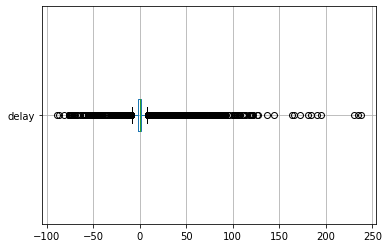

In [1009]:
#detecting outliers for delay
X_train.boxplot(column='delay', vert=False)

In [1010]:
print(X_train['delay'].min())
print(X_train['delay'].max())

-89.0
238.0


In [1011]:
# Detecting outliers
def find_skewed_boundaries(df,variable,distance):
    IQR=X_train[variable].quantile(0.75)-df[variable].quantile(0.25)
    
    upper_boundary=X_train[variable].quantile(0.75) + (IQR*distance)
    lower_boundary=X_train[variable].quantile(0.25) - (IQR*distance)
    
    return upper_boundary, lower_boundary

In [1012]:
lim=find_skewed_boundaries(X_train,'delay',3)

In [1013]:
lim[0],lim[1]

(14.0, -14.0)

In [1014]:
X_train = X_train[(X_train['delay'] < lim[0]) & (X_train['delay'] > lim[1])]
X_v1 = X_v1[(X_v1['delay'] < lim[0]) & (X_v1['delay'] > lim[1])]
X_v2 = X_v2[(X_v2['delay'] < lim[0]) & (X_v2['delay'] > lim[1])]

-13.0 13.0


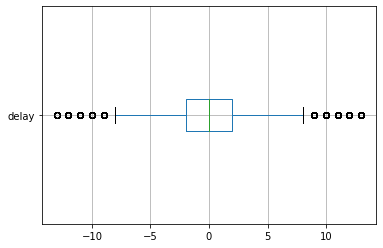

In [1015]:
print(X_train['delay'].min(), X_train['delay'].max())
X_train.boxplot(column='delay', vert=False)

-13.0 13.0


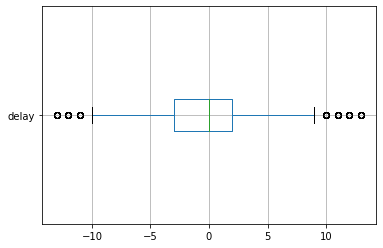

In [1016]:
print(X_v1['delay'].min(), X_v1['delay'].max())
X_v1.boxplot(column='delay', vert=False)

-13.0 13.0


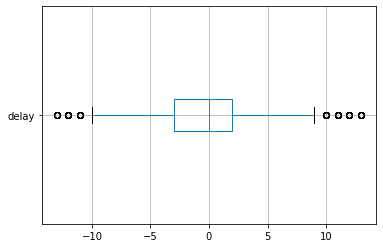

In [1017]:
print(X_v2['delay'].min(), X_v2['delay'].max())
X_v2.boxplot(column='delay', vert=False)

In [1018]:
#Train set
business_code_train = pd.get_dummies(X_train['business_code'], drop_first=True)
document_type_train = pd.get_dummies(X_train['document type'])

#Val set 1
business_code_v1 = pd.get_dummies(X_v1['business_code'], drop_first=True)
document_type_v1 = pd.get_dummies(X_v1['document type'])

#Val set 2
business_code_v2 = pd.get_dummies(X_v2['business_code'], drop_first=True)
document_type_v2 = pd.get_dummies(X_v2['document type'])

#Final Test Set
business_code_test = pd.get_dummies(test_df['business_code'], drop_first=True)
document_type_test = pd.get_dummies(test_df['document type'])

In [1019]:
X_train = pd.concat([X_train,document_type_train,business_code_train], axis=1)
X_v1 = pd.concat([X_v1,document_type_v1,business_code_v1], axis=1)
X_v2 = pd.concat([X_v2,document_type_v2,business_code_v2], axis=1)
test_df = pd.concat([test_df,document_type_test,business_code_test], axis=1)

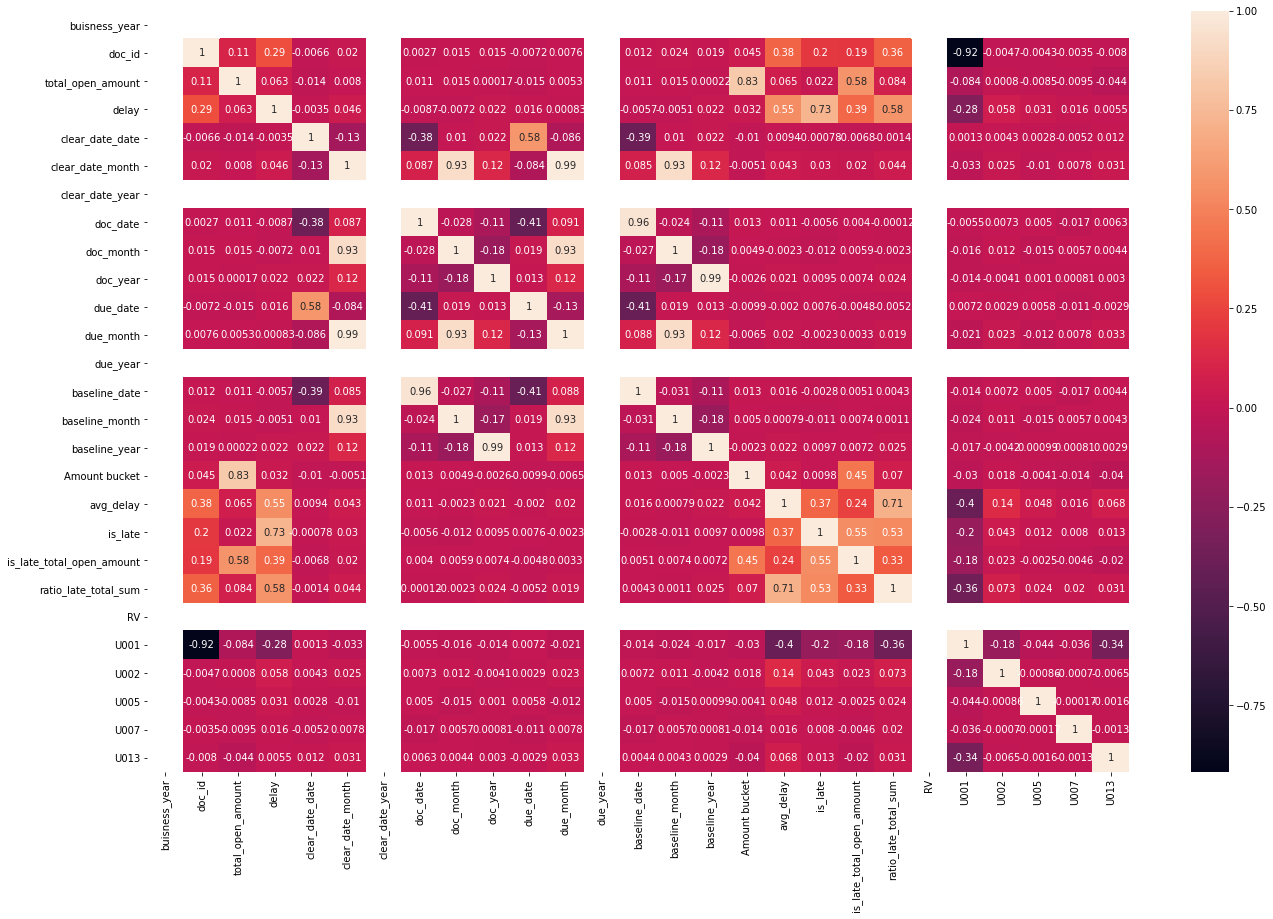

In [1020]:
correlation=X_train.corr()
plt.subplots(figsize=(22,14))
sns.heatmap(correlation,annot=True)

In [1021]:
X_train.columns

Index(['business_code', 'cust_number', 'clear_date', 'buisness_year', 'doc_id',
       'document_create_date.1', 'due_in_date', 'document type',
       'total_open_amount', 'baseline_create_date', 'cust_payment_terms',
       'delay', 'clear_date_date', 'clear_date_month', 'clear_date_year',
       'doc_date', 'doc_month', 'doc_year', 'due_date', 'due_month',
       'due_year', 'baseline_date', 'baseline_month', 'baseline_year',
       'Amount bucket', 'avg_delay', 'is_late', 'is_late_total_open_amount',
       'ratio_late_total_sum', 'RV', 'U001', 'U002', 'U005', 'U007', 'U013'],
      dtype='object')

In [1022]:
#Final train data preparation...
X_train_final = X_train.drop(['business_code', 'document type','Amount bucket', 'delay', 'is_late','clear_date', 'document_create_date.1', 'due_in_date', 'cust_payment_terms', 'cust_number','baseline_create_date'], axis=1)
print(X_train_final.shape)
X_train_final.dtypes

(29243, 24)


buisness_year                float64
doc_id                       float64
total_open_amount            float64
clear_date_date              float64
clear_date_month             float64
clear_date_year              float64
doc_date                     float64
doc_month                    float64
doc_year                     float64
due_date                     float64
due_month                    float64
due_year                     float64
baseline_date                float64
baseline_month               float64
baseline_year                float64
avg_delay                    float64
is_late_total_open_amount    float64
ratio_late_total_sum         float64
RV                             uint8
U001                           uint8
U002                           uint8
U005                           uint8
U007                           uint8
U013                           uint8
dtype: object

In [1023]:
#Preparing the final test data.
X_v1_final = X_v1.drop(['business_code', 'document type', 'delay','Amount bucket', 'is_late', 'clear_date', 'document_create_date.1', 'due_in_date', 'cust_payment_terms', 'cust_number','baseline_create_date',], axis=1)
print(X_v1_final.shape)
X_v1_final.dtypes

(6431, 22)


buisness_year                float64
doc_id                       float64
total_open_amount            float64
clear_date_date              float64
clear_date_month             float64
clear_date_year              float64
doc_date                     float64
doc_month                    float64
doc_year                     float64
due_date                     float64
due_month                    float64
due_year                     float64
baseline_date                float64
baseline_month               float64
baseline_year                float64
avg_delay                    float64
is_late_total_open_amount    float64
ratio_late_total_sum         float64
RV                             uint8
U001                           uint8
U002                           uint8
U013                           uint8
dtype: object

In [1024]:
X_v2_final = X_v2.drop(['business_code', 'document type', 'delay', 'clear_date','Amount bucket' , 'is_late','document_create_date.1', 'due_in_date', 'cust_payment_terms', 'cust_number','baseline_create_date', 'clear_date_month', 'doc_month', 'due_month', 'baseline_date', 'baseline_month', 'baseline_year', 'RV'], axis=1)
print(X_v2_final.shape)
X_v2_final.dtypes

(6304, 16)


buisness_year                float64
doc_id                       float64
total_open_amount            float64
clear_date_date              float64
clear_date_year              float64
doc_date                     float64
doc_year                     float64
due_date                     float64
due_year                     float64
avg_delay                    float64
is_late_total_open_amount    float64
ratio_late_total_sum         float64
U001                           uint8
U002                           uint8
U005                           uint8
U013                           uint8
dtype: object

In [1025]:
test_final = test_df.drop(['business_code', 'document type', 'delay','Amount bucket', 'clear_date', 'document_create_date.1', 'due_in_date', 'cust_payment_terms', 'cust_number','baseline_create_date', 'doc_month', 'due_month', 'baseline_date', 'baseline_month', 'baseline_year', 'RV', 'clear_date_month'], axis=1)
print(test_final.shape)
test_final.dtypes


(3202, 15)


buisness_year           float64
doc_id                  float64
total_open_amount       float64
clear_date_date         float64
clear_date_year         float64
doc_date                float64
doc_year                float64
due_date                float64
due_year                float64
avg_delay               float64
ratio_late_total_sum    float64
U001                      uint8
U002                      uint8
U005                      uint8
U013                      uint8
dtype: object

In [1026]:
test_final = test_final.fillna(0)

In [1027]:
#Finding and filling the missing columns in validation set with 0
missing_cols = set( X_train_final.columns ) - set( X_v1_final.columns )
for val in missing_cols:
    X_v1_final[val] = 0
X_v1_final = X_v1_final[X_train_final.columns]
X_v1_final[['clear_date_date','clear_date_month','clear_date_year']]=0
X_v1_final

,buisness_year,doc_id,total_open_amount,clear_date_date,clear_date_month,clear_date_year,doc_date,doc_month,doc_year,due_date,due_month,due_year,baseline_date,baseline_month,baseline_year,avg_delay,is_late_total_open_amount,ratio_late_total_sum,RV,U001,U002,U005,U007,U013
23096,2019.0,1.929980e+09,7664.54,0,0,0,8.0,10.0,2019.0,23.0,10.0,2019.0,8.0,10.0,2019.0,2.884026,7664.54,0.722156,1,1,0,0,0,0
38062,2019.0,1.929968e+09,14747.00,0,0,0,8.0,10.0,2019.0,23.0,10.0,2019.0,8.0,10.0,2019.0,1.123077,14747.00,0.605642,1,1,0,0,0,0
21484,2019.0,1.929983e+09,31035.40,0,0,0,8.0,10.0,2019.0,23.0,10.0,2019.0,8.0,10.0,2019.0,-2.298809,0.00,0.149284,1,1,0,0,0,0
24300,2019.0,1.929989e+09,95412.23,0,0,0,8.0,10.0,2019.0,9.0,11.0,2019.0,8.0,10.0,2019.0,0.116279,95412.23,0.370449,1,1,0,0,0,0
20182,2019.0,1.929983e+09,24119.59,0,0,0,8.0,10.0,2019.0,23.0,10.0,2019.0,8.0,10.0,2019.0,-2.298809,0.00,0.149284,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19676,2019.0,1.930260e+09,117968.74,0,0,0,10.0,12.0,2019.0,25.0,12.0,2019.0,10.0,12.0,2019.0,1.505689,0.00,0.611795,1,1,0,0,0,0
24694,2019.0,1.930254e+09,683.91,0,0,0,10.0,12.0,2019.0,25.0,12.0,2019.0,10.0,12.0,2019.0,-2.298809,0.00,0.149284,1,1,0,0,0,0
11628,2019.0,1.930260e+09,5390.92,0,0,0,10.0,12.0,2019.0,25.0,12.0,2019.0,10.0,12.0,2019.0,-2.298809,0.00,0.149284,1,1,0,0,0,0
5108,2019.0,1.930250e+09,45249.07,0,0,0,10.0,12.0,2019.0,25.0,12.0,2019.0,10.0,12.0,2019.0,-0.641509,0.00,0.023785,1,1,0,0,0,0


In [1028]:
missing_cols = set( X_train_final.columns ) - set( X_v2_final.columns )
for val in missing_cols:
    X_v2_final[val] = 0
X_v2_final = X_v2_final[X_train_final.columns]
X_v2_final[['clear_date_date','clear_date_month','clear_date_year']]=0
X_v2_final

,buisness_year,doc_id,total_open_amount,clear_date_date,clear_date_month,clear_date_year,doc_date,doc_month,doc_year,due_date,due_month,due_year,baseline_date,baseline_month,baseline_year,avg_delay,is_late_total_open_amount,ratio_late_total_sum,RV,U001,U002,U005,U007,U013
29870,2019.0,1.930250e+09,24829.43,0,0,0,10.0,0,2019.0,25.0,0,2019.0,0,0,0,-2.298809,0.00,0.149284,0,1,0,0,0,0
14877,2019.0,1.930254e+09,22499.73,0,0,0,10.0,0,2019.0,25.0,0,2019.0,0,0,0,-0.266342,22499.73,0.322161,0,1,0,0,0,0
21287,2019.0,2.960597e+09,107272.88,0,0,0,2.0,0,2019.0,20.0,0,2019.0,0,0,0,0.244898,0.00,0.324117,0,0,0,0,0,0
3540,2019.0,1.930260e+09,98239.93,0,0,0,10.0,0,2019.0,25.0,0,2019.0,0,0,0,0.963636,98239.93,0.612411,0,1,0,0,0,0
35134,2019.0,1.930259e+09,73641.77,0,0,0,10.0,0,2019.0,25.0,0,2019.0,0,0,0,0.560345,73641.77,0.436516,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13175,2020.0,2.960616e+09,5715.07,0,0,0,23.0,0,2020.0,13.0,0,2020.0,0,0,0,10.400000,5715.07,0.846468,0,0,0,0,0,0
36018,2020.0,2.960616e+09,2472.29,0,0,0,24.0,0,2020.0,14.0,0,2020.0,0,0,0,5.249071,2472.29,0.988355,0,0,0,0,0,0
3065,2020.0,2.960616e+09,79591.36,0,0,0,25.0,0,2020.0,15.0,0,2020.0,0,0,0,1.328685,79591.36,0.504150,0,0,0,0,0,0
46149,2020.0,2.960613e+09,3398.12,0,0,0,25.0,0,2020.0,16.0,0,2020.0,0,0,0,5.485294,3398.12,0.985700,0,0,0,0,0,0


In [1029]:
missing_cols = set( X_train_final.columns ) - set( test_final.columns )
for val in missing_cols:
    test_final[val] = 0
test_final = test_final[X_train_final.columns]
test_final

,buisness_year,doc_id,total_open_amount,clear_date_date,clear_date_month,clear_date_year,doc_date,doc_month,doc_year,due_date,due_month,due_year,baseline_date,baseline_month,baseline_year,avg_delay,is_late_total_open_amount,ratio_late_total_sum,RV,U001,U002,U005,U007,U013
46666,2020.0,1.930779e+09,3490.00,0.0,0,0.0,12.0,0,2020.0,27.0,0,2020.0,0,0,0,-2.298809,0,0.149284,0,1,0,0,0,0
46667,2020.0,1.930832e+09,40647.20,0.0,0,0.0,30.0,0,2020.0,15.0,0,2020.0,0,0,0,0.461538,0,0.205043,0,1,0,0,0,0
46668,2020.0,1.930575e+09,6520.80,0.0,0,0.0,28.0,0,2020.0,14.0,0,2020.0,0,0,0,-2.298809,0,0.149284,0,1,0,0,0,0
46669,2020.0,1.930712e+09,12134.27,0.0,0,0.0,27.0,0,2020.0,11.0,0,2020.0,0,0,0,-2.298809,0,0.149284,0,1,0,0,0,0
46670,2020.0,1.930605e+09,18069.57,0.0,0,0.0,4.0,0,2020.0,24.0,0,2020.0,0,0,0,-5.076923,0,0.177547,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,2020.0,1.930759e+09,1898.90,0.0,0,0.0,6.0,0,2020.0,21.0,0,2020.0,0,0,0,-2.298809,0,0.149284,0,1,0,0,0,0
49996,2020.0,1.930558e+09,26226.85,0.0,0,0.0,27.0,0,2020.0,27.0,0,2020.0,0,0,0,43.086460,0,0.997888,0,1,0,0,0,0
49997,2020.0,2.960617e+09,52589.07,0.0,0,0.0,27.0,0,2020.0,9.0,0,2020.0,0,0,0,6.112727,0,0.997009,0,0,0,0,0,0
49998,2020.0,1.930661e+09,30717.94,0.0,0,0.0,19.0,0,2020.0,3.0,0,2020.0,0,0,0,-2.298809,0,0.149284,0,1,0,0,0,0


XGBRegressor

In [1030]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [1031]:
MSE_Score=[]
RMSE_Score=[]
Algorithm=[]

In [1032]:
# XGBoost val1
Algorithm.append('XGB Regressor For Validation 1')
clf = xgb.XGBRegressor(eta=0.06,max_depth=8)
clf.fit(X_train_final, X_train['delay'])
predicted = clf.predict(X_v1_final)

[06:42:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [1033]:
MSE_Score.append(mean_squared_error(X_v1['delay'], predicted))
RMSE_Score.append(mean_squared_error(X_v1['delay'], predicted, squared=False))

In [1034]:
# XGBoost val2
Algorithm.append('XGB Regressor For Validation 2')
predicted = clf.predict(X_v2_final)

In [1035]:
MSE_Score.append(mean_squared_error(X_v2['delay'], predicted))
RMSE_Score.append(mean_squared_error(X_v2['delay'], predicted, squared=False))

In [1036]:
Comparison = pd.DataFrame(list(zip(Algorithm,MSE_Score,RMSE_Score)),columns=['Algorithm','MSE_Score','RMSE_Score'])
Comparison

,Algorithm,MSE_Score,RMSE_Score
0,XGB Regressor For Validation 1,24.829384,4.982909
1,XGB Regressor For Validation 2,21.619168,4.649642


Random Forest Regressor

In [1038]:
from sklearn.ensemble import RandomForestRegressor

In [1039]:
# Fitting Random Forest Regressor Tree to the Training Set
Algorithm.append('Random Forest Regressor for validation 1')
clf = RandomForestRegressor()
clf.fit(X_train_final,  X_train['delay'])



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [1040]:
# Random Forest for validation 1
predicted = clf.predict(X_v1_final)

In [1041]:
MSE_Score.append(mean_squared_error(X_v1['delay'], predicted))
RMSE_Score.append(mean_squared_error(X_v1['delay'], predicted, squared=False))

In [1042]:
# Random Forest for validation 2
Algorithm.append('Random Forest Regressor for validation 2')
predicted = clf.predict(X_v2_final)

In [1043]:
MSE_Score.append(mean_squared_error(X_v2['delay'], predicted))
RMSE_Score.append(mean_squared_error(X_v2['delay'], predicted, squared=False))

In [1044]:
Comparison = pd.DataFrame(list(zip(Algorithm,MSE_Score,RMSE_Score)),columns=['Algorithm','MSE_Score','RMSE_Score'])
Comparison

,Algorithm,MSE_Score,RMSE_Score
0,XGB Regressor For Validation 1,24.829384,4.982909
1,XGB Regressor For Validation 2,21.619168,4.649642
2,Random Forest Regressor for validation 1,5.981913,2.445795
3,Random Forest Regressor for validation 2,6.500062,2.549522


In [1048]:
for i in clf.predict(test_final):
  print(round(i))

-4
0
-5
-5
-6
-4
-2
-7
-2
-3
-4
-4
-1
-4
-1
-2
-2
-1
-4
-5
-8
0
-1
-5
-1
-8
-2
-4
-5
-5
-1
0
-5
-1
-4
-5
-2
-6
-5
-2
-4
-1
-1
-2
-6
-1
-1
-1
-6
-2
-4
-1
-2
-4
-2
-1
-7
-4
-1
-4
-3
-2
-8
-2
-4
-3
-1
-1
-1
-5
-5
-1
-4
-1
-1
-1
-3
-1
-4
-7
-1
-2
-5
-5
-1
-7
-4
-1
-1
-5
-5
-4
-1
-1
-5
-4
-2
-1
-1
-2
-1
-4
-5
-7
-4
-2
-1
-4
-6
-6
-4
-1
-1
-6
-4
-3
-2
-2
-1
-5
-3
-4
-7
-1
-1
-2
-1
-5
-4
-1
-4
-2
-1
-5
-4
-5
0
-7
-1
-1
-5
-5
-3
-4
-2
-4
-1
0
-2
-4
-4
-1
-4
-3
-7
-5
-1
-5
-4
-1
-2
-5
-3
0
-2
-4
-1
-1
-1
-2
-2
-2
0
0
-2
-1
0
-1
-1
-3
-3
-4
-6
-1
-1
0
-4
-3
-3
-6
-5
-4
-6
-5
-7
-7
-1
-5
-1
-5
-4
-5
-2
-2
-1
-5
-5
-6
-1
-5
-2
-1
-2
-6
-4
-4
-4
-5
-3
-4
-5
-1
-4
-4
-3
-8
-1
-2
-5
-4
-1
-5
-1
-5
-1
-3
0
-3
-3
-4
-4
-3
-1
-2
-6
-5
-1
-6
-1
-5
-5
-1
-3
-4
-4
-5
-4
-5
-2
-8
-4
-4
-5
-1
-4
-1
-7
-5
-2
-4
-5
-1
-1
-1
-5
-1
-2
-6
-4
-7
-4
-2
-5
-5
-2
-1
-2
-1
-4
-5
0
-7
-2
0
-1
-1
-4
-6
-4
-4
-6
-4
-1
-3
-6
-8
0
-2
-2
0
-4
-5
-6
-5
-7
-1
-7
-2
0
-4
-7
-4
-6
-4
-1
-4
-1
-1
-4
-7
-4
-3
-5
-4
-5
-2
-3
-4
-3